## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

In [1]:
from __future__ import print_function
#import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [3]:
# установка параметров нейросети
num_classes = 10
num_predictions = 20

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


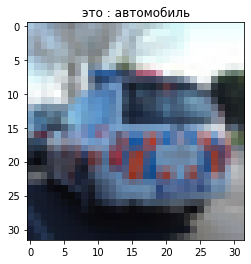

In [4]:
N = 1131
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

In [44]:
def build_model(n_edges, n_additional_conv_layers):
  model = Sequential()
  # слои нейросети отвественные за свертку и max-pooling
  model.add(Conv2D(n_edges, (3, 3), padding='same',
                  input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(n_edges, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout( 0.25))
  for i in range(2, n_additional_conv_layers+2):
    model.add(Conv2D(n_edges * i, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(n_edges * i, (3, 3)))
    model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  # полносвязные слои нейронной сети
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  # инициализация RMSprop optimizer
  opt = RMSprop(learning_rate=0.0001, decay=1e-6)

  # компиляция модели
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model

def fit_model(model, x_train, y_train, x_test, y_test, callback_filepath, data_augmentation=False):
  checkpoint = ModelCheckpoint(filepath=callback_filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
  EarlyStop = EarlyStopping(monitor='val_loss', patience=4)
  callbacks = [checkpoint, EarlyStop]
  
  
  if not data_augmentation:
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              verbose=0,
              callbacks=callbacks)
  else:
    datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False, 
            zca_epsilon=1e-06, 
            rotation_range=5, 
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0., 
            zoom_range=0., 
            channel_shift_range=0.,
            fill_mode='nearest',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=False,
            rescale=None,
            preprocessing_function=None,
            data_format=None,
            validation_split=0.0)

    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
              epochs=epochs,
              validation_data=(x_test, y_test),
              workers=-1,
              verbose=0,
              callbacks=callbacks)

In [6]:
data_augmentation = False
epochs = 80
batch_size = 128
n_tests = 1
results_n_edges = []

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

for test in range(n_tests):
  for n_edges in [32, 48, 64, 96]:
    model = build_model(n_edges=n_edges, n_additional_conv_layers=1)
    fit_model(model, x_train, y_train, x_test, y_test, model_path, data_augmentation=False)
    best_model = load_model(model_path)
    scores = best_model.evaluate(x_test, y_test, verbose=1)
    results_n_edges.append(
        {
            'test_number': test,
            'n_edges': n_edges,
            'Test loss:': scores[0], 
            'Test accuracy:': scores[1]
        })
    print(f'test {test}: n_edges: {n_edges}, test_acc: {scores[1]}')

313/313 [==============================] - 2s 6ms/step - loss: 0.6598 - accuracy: 0.7714
test 0: n_edges: 32, test_acc: 0.771399974822998
313/313 [==============================] - 2s 6ms/step - loss: 0.6226 - accuracy: 0.7885
test 0: n_edges: 48, test_acc: 0.7885000109672546
313/313 [==============================] - 3s 8ms/step - loss: 0.5983 - accuracy: 0.8000
test 0: n_edges: 64, test_acc: 0.800000011920929
313/313 [==============================] - 3s 9ms/step - loss: 0.5797 - accuracy: 0.8051
test 0: n_edges: 96, test_acc: 0.8051000237464905


In [7]:
pd.DataFrame(results_n_edges).groupby('n_edges').agg({'Test accuracy:' : ['mean', 'max', 'std']})

Test accuracy:            
                  mean     max std
n_edges                           
32              0.7714  0.7714 NaN
48              0.7885  0.7885 NaN
64              0.8000  0.8000 NaN
96              0.8051  0.8051 NaN

In [45]:
results_n_layers = []
for test in range(n_tests):
  for n_layers in [2, 3, 4]:
    model = build_model(n_edges=64, n_additional_conv_layers=n_layers)
    fit_model(model, x_train, y_train, x_test, y_test, model_path, data_augmentation=False)
    best_model = load_model(model_path)
    scores = best_model.evaluate(x_test, y_test, verbose=1)
    results_n_layers.append(
        {
            'test_number': test,
            'n_edges': n_edges,
            'Test loss:': scores[0], 
            'Test accuracy:': scores[1]
        })
    print(f'test {test}: n_edges: {n_layers}, test_acc: {scores[1]}')

313/313 [==============================] - 4s 11ms/step - loss: 0.5646 - accuracy: 0.8110
test 0: n_edges: 2, test_acc: 0.8109999895095825
313/313 [==============================] - 5s 13ms/step - loss: 0.6406 - accuracy: 0.7783
test 0: n_edges: 3, test_acc: 0.7782999873161316
313/313 [==============================] - 5s 16ms/step - loss: 0.5956 - accuracy: 0.8048
test 0: n_edges: 4, test_acc: 0.8047999739646912


 Увеличение количества ядер в большей степени улучшает точность модели, в отличие от увеличения её глубины